

<!-- ![](https://cdn.dribbble.com/users/2353146/screenshots/9073115/media/eadd1ef050b49fbdf20d42e7c504458d.png)
Image is made by [Алена Молчанова](https://dribbble.com/shots/9073115-WRITING?utm_source=Clipboard_Shot&utm_campaign=mimipig&utm_content=WRITING&utm_medium=Social_Share&utm_source=Clipboard_Shot&utm_campaign=mimipig&utm_content=WRITING&utm_medium=Social_Share) -->

# Here is a baseline notebook for [Feedback Prize - Evaluating Student Writing](https://www.kaggle.com/c/feedback-prize-2021/)


**The notebook outline:** 
1. spacy EDA 
2. Text preprocessing and transforming data to sentences using this great notebook: [📖Feedback- Baseline🤗 Sentence Classifier [0.226]](https://www.kaggle.com/julian3833/feedback-baseline-sentence-classifier-0-226)
3. Train model with [ULMFIT](https://arxiv.org/pdf/1708.02182v1.pdf) using fastai library for sentence classficiation
4. Submit




In [ ]:
!pip install kaggle
import zipfile

!kaggle competitions download -c feedback-prize-2021 -p ../input/feedback-prize-2021
!kaggle datasets download  -d cdeotte/tf-longformer-v12 -p ../input/tf-longformer-v12

with zipfile.ZipFile('../input/feedback-prize-2021/feedback-prize-2021.zip','r') as myzip:
    myzip.extractall('../input/feedback-prize-2021')

with zipfile.ZipFile('../input/tf-longformer-v12/tf-longformer-v12.zip','r') as myzip:
    myzip.extractall('../input/tf-longformer-v12')


### First we do necessary imports and load the data

In [1]:
from fastai.text import *
from fastai.text.all import *
import nltk
import spacy
import pandas as pd
import numpy as np
import fastai
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
tqdm.pandas()
print(f"fastai version: {fastai.__version__}")
if torch.cuda.is_available():
    print(f"GPU which is used : {torch.cuda.get_device_name(0)}")
    

## defining directories
root = Path().absolute()
data_dir = root / "../input/feedback-prize-2021"
train_text_dir = data_dir / "train"
test_text_dir = data_dir / "test"
out = root / "out"
out.mkdir(exist_ok=True)
# data_dir.ls()

fastai version: 2.5.3
GPU which is used : Tesla P100-PCIE-16GB


In [2]:
df = pd.read_csv(data_dir / "train.csv", dtype={'discourse_id': int, 'discourse_start': int, 'discourse_end': int})
print('\nHere is the data sample : \n\n')
df.head(2)


Here is the data sample : 




,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stuff happens when it comes to a phone.,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59


### Visualize classes

In [3]:
def visualize_classes(file_name):
    ents = []
    for i, row in df[df['id'] == file_name].iterrows():
        ents.append({
                        'start': int(row['discourse_start']), 
                         'end': int(row['discourse_end']), 
                         'label': row['discourse_type']
                    })
    with open(f'{train_text_dir}/{file_name}.txt', 'r') as file: data = file.read()

    doc2 = {
        "text": data,
        "ents": ents,
        "title": file_name
    }
    colors = {'Lead': '#c1dbd5',
            'Position': '#fcf2b6',
            'Claim': '#bbceae',
            'Evidence': '#c8f1bf',
            'Counterclaim': '#d3b88a',
            'Concluding Statement': '#ed9a8b',
            'Rebuttal': '#ef8c9d'}

    options = {"ents": df.discourse_type.unique().tolist(), "colors": colors}
    spacy.displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True)
    print('\n')

Visualize 4 sample of data

In [4]:
for i in df['id'].sample(n=4, random_state=2).values.tolist():
    visualize_classes(i)

### preprocessing

Convert classes into ints, also we put `No Class` for sentences with no label

In [5]:
ID2CLASS = dict(enumerate(df['discourse_type'].unique().tolist() + ['No Class']))
CLASS2ID = {v: k for k, v in ID2CLASS.items()}
# print(ID2CLASS)
CLASS2ID

{'Lead': 0,
 'Position': 1,
 'Evidence': 2,
 'Claim': 3,
 'Concluding Statement': 4,
 'Counterclaim': 5,
 'Rebuttal': 6,
 'No Class': 7}

And here are some helper functions to transform data to sentences
* fill_gaps(), classifies parts of the texts that has not label as "No Class" 
* get_elements(), creates a list of text sections for a each text
* get_x_samples(), maps each sentences to their labels.

In [6]:
def get_text(source_dir,a_id):
    a_file = f"{source_dir}/{a_id}.txt"
    with open(a_file, "r") as fp:
        txt = fp.read()
    return txt

def fill_gaps(elements, text):
    """Add "No Class" elements to a list of elements (see get_elements) """
    initial_idx = 0
    final_idx = len(text)

    # Add element at the beginning if it doesn't in index 0
    new_elements = []
    if elements[0][0] != initial_idx:
        starting_element = (0, elements[0][0]-1, 'No Class')
        new_elements.append(starting_element)


    # Add element at the end if it doesn't in index "-1"
    if elements[-1][1] != final_idx:
        closing_element = (elements[-1][1]+1, final_idx, 'No Class')
        new_elements.append(closing_element)

    elements += new_elements
    elements = sorted(elements, key=lambda x: x[0])

    # Add "No class" elements inbetween separated elements 
    new_elements = []
    for i in range(1, len(elements)-1):
        if elements[i][0] != elements[i-1][1] + 1 and elements[i][0] != elements[i-1][1]:
            new_element = (elements[i-1][1] + 1, elements[i][0]-1, 'No Class')
            new_elements.append(new_element)

    elements += new_elements
    elements = sorted(elements, key=lambda x: x[0])
    return elements


def get_elements(df, text_id, do_fill_gaps=True, text=None):
    """Get a list of (start, end, class) elements for a given text_id"""
    text = get_text(text_id) if text is None else text
    df_text = df[df['id'] == text_id]
    elements = df_text[['discourse_start', 'discourse_end', 'discourse_type']].to_records(index=False).tolist()
    if do_fill_gaps:
        elements = fill_gaps(elements, text)
    return elements

def get_x_samples(df, text_id, do_fill_gaps=True):
    """Create a dataframe of the sentences of the text_id, with columns text, label """
    text = get_text(train_text_dir,text_id)
    elements = get_elements(df, text_id, do_fill_gaps, text)
    sentences = []
    for start, end, class_ in elements:
        elem_sentences = nltk.sent_tokenize(text[start:end])
        sentences += [(sentence, class_) for sentence in elem_sentences]
    df = pd.DataFrame(sentences, columns=['text', 'label'])
    df['label'] = df['label'].map(CLASS2ID)
    return df

In [7]:
text_ids = df['id'].unique().tolist()

And here we build our sentence dataframe

In [8]:
x = []
for text_id in tqdm(text_ids):
    x.append(get_x_samples(df, text_id))

df_sentences = pd.concat(x)
df_sentences = df_sentences[df_sentences.text.str.split().str.len() >= 3]
df_sentences.to_csv("df_sentence.csv", index=False)

  0%|          | 0/15594 [00:00<?, ?it/s]

Slice trainset, in order to train the kernel faster

It should be removed when training model for submission

In [9]:
df_sample = df_sentences.sample(n=3000, random_state=42)
print('class distribution in sample set :')
df_sample['label'].value_counts()

class distribution in sample set :


2    1457
3     488
4     366
0     235
1     179
7     150
5      66
6      59
Name: label, dtype: int64

### Finetune AWD-LSTM on our corpus to train [ULMFIT](https://docs.fast.ai/tutorial.text.html) 

Create [TextDataLoaders](https://docs.fast.ai/text.data.html#TextDataLoaders.from_df) from our df_sentences. keep in mind that using `is_lm` to `True` because later on we want to use it for finetuning our language model.

In [10]:
dls_lm = TextDataLoaders.from_df(df_sample, path=data_dir,is_lm=True)
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj also , there can always be that one person i m not saying to keep your xxunk small what i m saying is everyone is not always xxunk xxunk give you the right xxunk xxbos sincerely your student . xxbos xxmaj electoral xxmaj college xxunk problem with run - xxunk in which no candidate recieves a majority vote cast , which is the popular vote . xxbos xxmaj you know","xxmaj also , there can always be that one person i m not saying to keep your xxunk small what i m saying is everyone is not always xxunk xxunk give you the right xxunk xxbos sincerely your student . xxbos xxmaj electoral xxmaj college xxunk problem with run - xxunk in which no candidate recieves a majority vote cast , which is the popular vote . xxbos xxmaj you know all"
1,"with me and that walking on the green going to xxunk please give us a break that 's why xxunk cut up all the time because you always say walk on the green it is making us cut up like that since xxmaj elementary school we did n't have to walk on the green but now we are in middle school we have to walk on the green , i mean come","me and that walking on the green going to xxunk please give us a break that 's why xxunk cut up all the time because you always say walk on the green it is making us cut up like that since xxmaj elementary school we did n't have to walk on the green but now we are in middle school we have to walk on the green , i mean come on"
2,"to do the sport they want to do for a living and school can get in the way if they needed to do an extra sport . xxbos xxmaj xxunk , xxmaj robert xxmaj duffer xxunk "" paris bans driving due to xxunk "" explaining how "" paris xxunk has more smog than other xxmaj xxunk xxunk … "" xxmaj in xxmaj paris , many people are using cars , and","do the sport they want to do for a living and school can get in the way if they needed to do an extra sport . xxbos xxmaj xxunk , xxmaj robert xxmaj duffer xxunk "" paris bans driving due to xxunk "" explaining how "" paris xxunk has more smog than other xxmaj xxunk xxunk … "" xxmaj in xxmaj paris , many people are using cars , and they"


and save dataloader for later use

In [11]:
torch.save(dls_lm, out / 'dls_lm.pkl')
# dls_lm = torch.load(out / 'dls_lm.pkl')

Here we instantiate our [language_model_learner](https://docs.fast.ai/text.learner.html#language_model_learner) and using [Mixed precision training](https://docs.fast.ai/callback.fp16.html#Learner.to_fp16) by adding `.to_fp16()` at the end of code

In [12]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=data_dir, wd=0.1, model_dir="/tmp/model/").to_fp16()

Using learning rate finder of fastai. Here we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of the learning rate, so we plot with a log scale. Then, we choose a value that is approximately in the middle of the sharpest downward slope.

For more information on the finding the good learning rate you can refer to this post: [how do you find a good learning rate](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)

SuggestedLRs(valley=0.0063095735386013985)

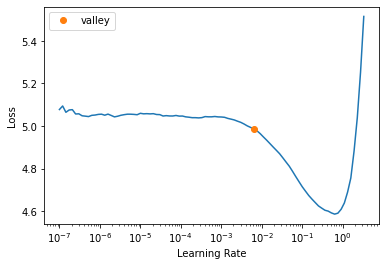

In [13]:
learn.lr_find()

Next, we finetune the model. By default, a pretrained Learner is in a frozen state, meaning that only the head of the model will train while the body stays frozen.

In [14]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.026124,4.742890,0.222184,114.765381,00:04


We can then fine-tune the model after unfreezing

In [15]:
learn.unfreeze()
learn.fit_one_cycle(7, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.923365,4.541959,0.227180,93.874550,00:03
1,4.729621,4.170433,0.236116,64.743484,00:03
2,4.547795,3.956281,0.249683,52.262623,00:03
3,4.409132,3.882116,0.272899,48.526806,00:03
4,4.312719,3.856793,0.276535,47.313358,00:03
5,4.251746,3.845789,0.278461,46.795601,00:03
6,4.207500,3.844001,0.278605,46.711975,00:03


Saving encoder for later use in text classification
NOTE THAT

`
Encoder: The model not including the task-specific final layer(s). It means much the same thing as body when applied to vision CNNs, but tends to be more used for NLP and generative models
`

In [16]:
learn.save_encoder(out / 'finetuned')

Here we gather our data for text classification almost exactly like before.

The main difference is that we have to use the exact same vocabulary as when we were fine-tuning our language model, or the weights learned won't make any sense. We pass that vocabulary with vocab by adding `text_vocab=dls_lm.vocab`

In [17]:
dls_clas = TextDataLoaders.from_df(df_sentences, path=data_dir, text_col='text', label_col='label',text_vocab=dls_lm.vocab)
dls_clas.show_batch(max_n=3)

,text,category
0,xxbos the presidental election is to find a new leader of the united states he xxunk has to pass laws and do xxunk we vote to make sure we get the right president we do nt want someone that s xxunk xxunk make xxunk laws and xxunk the people to much the president has to take charge has to go to ▁ world xxunk has to be a role model for the xxunk people in the world the president has to do alot of work now the xxunk president has to do what the president ca nt do sometimes other times he s just there to help the president when he needs him like when the presidents gone on xxunk the xxunk president does his work for him but sometimes the xxunk president xxunk up with xxunk so that s why we need to chose the best president not someone,2
1,xxbos community service it is also good because the way you are not always in your house trying to figure out what are you going to do because your bored or you will not be just xxunk down in the bed or in the xxunk playing video games or watching a movie because over time that will get boring for you and it will xxunk your healthy so that 's why its good to do community service even ones a week or in a xxunk its not bad to do community service i do community service all xxmaj xxunk and sometimes over the xxunk it is so fun to do community service because i spend some times with my friends with out going to the xxunk or anything like that so it will be good for other student to do some community services so they can see that it is,2
2,"xxbos xxmaj overall , i think that having a rule that makes all students participate in an extracurricular activity is a good idea because it keeps students active and participating in something , it allows you to socialize with ones you do n't know and ones you do , it also gives you more options for a xxunk , maybe you could find something that you are interested in to study later in life , it can give you a chance to find something new that you did n't know you xxunk before , and finally , it xxunk important skills that will help you throughout your entire life .",4


In [18]:
torch.save(dls_clas, out / 'dls_clas.pkl')
# dls_clas = torch.load(out / 'dls_clas.pkl')

Then we can define our text classifier like before:

Defing metrics: we use [accuracy](https://docs.fast.ai/metrics.html#accuracy) and [F1Score](https://docs.fast.ai/metrics.html#F1Score)

In [19]:
metrics=[accuracy,F1Score(average='micro')]
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=metrics, model_dir="/tmp/model/")

As said before we load our encoder that we saved so that we use the exact same vocabulary as when we were fine-tuning our language model.

In [20]:
learn = learn.load_encoder(out / 'finetuned')

SuggestedLRs(valley=0.0020892962347716093)

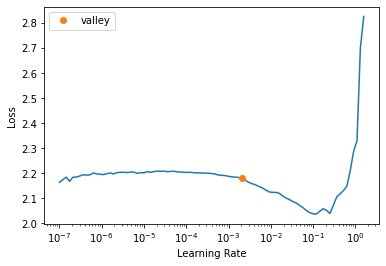

In [21]:
learn.lr_find()

In [22]:
lr = 1e-2
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.347327,1.248083,0.578035,0.578035,06:41


The last step is to train with discriminative learning rates and gradual unfreezing. In computer vision, we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference.

Here is abit of information about using `slice` in learning rate

Applying different lr for different groups is a technique called “discriminative layer training” that is introduced in part 1. This technique is commonly used in both computer vision and natural language processing.
you can find some good info by reading this blog post: [The 1cycle policy](https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy)

slice() can be passed 1 or 2 arguments only. Below is a snippet of experiments for your reference:

```python
In [9]: slice(5)
Out[9]: slice(None, 5, None)

In [10]: slice(1, 5)
Out[10]: slice(1, 5, None)
```

Therefore, in your last line, `slice(5e-3/(2.6**4),5e-3)` is equivalent to `slice(start = 5e-3/(2.6**4), stop = 5e-3, step = None)`

In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.192288,1.136398,0.621922,0.621922,06:52


In [24]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.114476,1.089705,0.636906,0.636906,07:07


In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.085502,1.075629,0.642163,0.642163,07:21
1,1.056891,1.064569,0.645180,0.645180,07:22


### Prepare test data

In [26]:
def create_df_test():
    test_ids = [f[:-4] for f in os.listdir(test_text_dir)]
    test_data = []
    for test_id in test_ids:
        text = get_text(test_text_dir, test_id)
        sentences = nltk.sent_tokenize(text)
        id_sentences = []
        idx = 0 
        for sentence in sentences:
            id_sentence = []
            words = sentence.split()
            # I created this heuristic for mapping words in senteces to "word indexes"
            # This is not definitive and might have strong drawbacks and problems
            for w in words:
                id_sentence.append(idx)
                idx+=1
            id_sentences.append(id_sentence)
        test_data += list(zip([test_id] * len(sentences), sentences, id_sentences))
    df_test = pd.DataFrame(test_data, columns=['id', 'text', 'ids'])
    return df_test

In [27]:
df_test = create_df_test()
df_test.head()

,id,text,ids
0,0FB0700DAF44,"During a group project, have you ever asked a group member about adding or replacing something?","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]"
1,0FB0700DAF44,"Or, when you were studying for a math test, did you ever ask your parents or sibling about different ways to tackle a certain problem?","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]"
2,0FB0700DAF44,Asking for other's opinions is especially beneficial as it allows for an individual to receive a variety of different views towards a given topic.,"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]"
3,0FB0700DAF44,"Likewise, being diverse and asking many people for their opinions allows one to understand how most people percieve something.","[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]"
4,0FB0700DAF44,This is especially important as knowing multiple opinions can allow someone to take those views into account and sway themseleves to the general audience.,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]"


### Make prediction

In [28]:
def predict(txt):
    with learn.no_bar(), learn.no_logging():
        return int(learn.predict(txt)[0])

In [29]:
df_test['predictions'] = df_test["text"].progress_apply(lambda x: predict(x))

df_test['class'] = df_test['predictions'].map(ID2CLASS)
df_test.head()

  0%|          | 0/187 [00:00<?, ?it/s]

,id,text,ids,predictions,class
0,0FB0700DAF44,"During a group project, have you ever asked a group member about adding or replacing something?","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]",2,Evidence
1,0FB0700DAF44,"Or, when you were studying for a math test, did you ever ask your parents or sibling about different ways to tackle a certain problem?","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]",2,Evidence
2,0FB0700DAF44,Asking for other's opinions is especially beneficial as it allows for an individual to receive a variety of different views towards a given topic.,"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]",3,Claim
3,0FB0700DAF44,"Likewise, being diverse and asking many people for their opinions allows one to understand how most people percieve something.","[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]",2,Evidence
4,0FB0700DAF44,This is especially important as knowing multiple opinions can allow someone to take those views into account and sway themseleves to the general audience.,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]",2,Evidence


Turn the word ids into predictionstring 

In [30]:
df_test['predictionstring'] = df_test['ids'].apply(lambda x: ' '.join([str(i) for i in x]))
df_test.head()

,id,text,ids,predictions,class,predictionstring
0,0FB0700DAF44,"During a group project, have you ever asked a group member about adding or replacing something?","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]",2,Evidence,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
1,0FB0700DAF44,"Or, when you were studying for a math test, did you ever ask your parents or sibling about different ways to tackle a certain problem?","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]",2,Evidence,16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
2,0FB0700DAF44,Asking for other's opinions is especially beneficial as it allows for an individual to receive a variety of different views towards a given topic.,"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]",3,Claim,41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
3,0FB0700DAF44,"Likewise, being diverse and asking many people for their opinions allows one to understand how most people percieve something.","[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]",2,Evidence,65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
4,0FB0700DAF44,This is especially important as knowing multiple opinions can allow someone to take those views into account and sway themseleves to the general audience.,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]",2,Evidence,84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107


Drop the sentences with label "No class" 

In [31]:
df_test = df_test[df_test['class'] != 'No Class']
df_test.head()

,id,text,ids,predictions,class,predictionstring
0,0FB0700DAF44,"During a group project, have you ever asked a group member about adding or replacing something?","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]",2,Evidence,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
1,0FB0700DAF44,"Or, when you were studying for a math test, did you ever ask your parents or sibling about different ways to tackle a certain problem?","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]",2,Evidence,16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
2,0FB0700DAF44,Asking for other's opinions is especially beneficial as it allows for an individual to receive a variety of different views towards a given topic.,"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]",3,Claim,41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
3,0FB0700DAF44,"Likewise, being diverse and asking many people for their opinions allows one to understand how most people percieve something.","[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]",2,Evidence,65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
4,0FB0700DAF44,This is especially important as knowing multiple opinions can allow someone to take those views into account and sway themseleves to the general audience.,"[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]",2,Evidence,84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107


In [32]:
# submit
df_test[['id', 'class', 'predictionstring']].to_csv("submission.csv", index=False)

**Refrences:**

- [Transfer learning in text](https://docs.fast.ai/tutorial.text.html)
- [Efficient multi-lingual language model fine-tuning](https://nlp.fast.ai/)
- [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146)